In [ ]:
# Monkeypox Classification with Dilated-CNN + Attention in PyTorch
# Optimized for Google Colab

# Install necessary libraries
# !pip install -q albumentations

# Import libraries
import os
import sys
import zipfile
import shutil
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, WeightedRandomSampler, Dataset
import torchvision
from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [ ]:
class DatasetManager:
    """Handles dataset extraction, cleaning, and preprocessing"""
    def __init__(self, zip_path, extract_to='./dataset'):
        self.zip_path = zip_path
        self.extract_to = Path(extract_to)
        self.base_path = None
        self.classes = ['Chickenpox', 'Cowpox', 'HFMD', 'Measles', 'Monkeypox', 'Normal']
        self.splits = ['train', 'val', 'test']

        if not os.path.exists(zip_path):
            raise FileNotFoundError(f"Zip file not found at: {zip_path}")

    def extract_and_setup(self):
        """Extract zip file and setup folder structure"""
        print("Extracting dataset...")

        # Clean up existing directory
        if self.extract_to.exists():
            shutil.rmtree(self.extract_to)

        try:
            with zipfile.ZipFile(self.zip_path, 'r') as zip_ref:
                zip_ref.extractall(self.extract_to)
        except Exception as e:
            raise Exception(f"Failed to extract zip file: {e}")

        # Find the correct dataset path
        possible_paths = [
            self.extract_to / 'monkeypox_dataset',
            self.extract_to / 'dataset' / 'monkeypox_dataset',
        ]

        # Also search for any folder containing relevant structure
        for item in self.extract_to.rglob('*'):
            if item.is_dir() and any(split in item.name.lower() for split in ['train', 'test', 'val']):
                possible_paths.append(item.parent)

        for path in possible_paths:
            if path and path.exists():
                train_path = path / 'train'
                if train_path.exists():
                    self.base_path = path
                    break

        if self.base_path is None:
            print("Extracted contents:")
            for item in self.extract_to.rglob('*'):
                print(f"  {item}")
            raise Exception("Could not find dataset with expected structure")

        print(f"Dataset extracted to: {self.base_path}")
        return self.clean_dataset()

    def clean_dataset(self):
        """Clean corrupt images and analyze distribution"""
        print("Cleaning dataset...")
        counts = {}
        corrupt_count = 0

        for split in self.splits:
            counts[split] = {}
            split_path = self.base_path / split

            if not split_path.exists():
                print(f"Warning: Split {split} does not exist")
                for cls in self.classes:
                    counts[split][cls] = 0
                continue

            for cls in self.classes:
                cls_path = split_path / cls
                if not cls_path.exists():
                    counts[split][cls] = 0
                    continue

                valid_images = []
                for img_path in cls_path.glob('*'):
                    if img_path.suffix.lower() in ['.jpg', '.jpeg', '.png']:
                        try:
                            with Image.open(img_path) as img:
                                img.verify()
                            with Image.open(img_path) as img:
                                img.load()
                            valid_images.append(img_path)
                        except Exception:
                            print(f"Removing corrupt image: {img_path}")
                            try:
                                img_path.unlink()
                                corrupt_count += 1
                            except:
                                pass

                counts[split][cls] = len(valid_images)

        print(f"Removed {corrupt_count} corrupt images")

        # Create DataFrame and display
        df_counts = pd.DataFrame(counts).T
        print("\nDataset distribution:")
        print(df_counts)

        # Plot distribution
        plt.figure(figsize=(12, 6))
        df_counts.plot(kind='bar', stacked=True, ax=plt.gca())
        plt.title('Dataset Distribution After Cleaning')
        plt.ylabel('Number of Images')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        return df_counts

In [ ]:
class DilatedAttentionBlock(nn.Module):
    """Dilated Attention Block with proper initialization"""
    def __init__(self, in_channels, out_channels, dilation_rate=2):
        super(DilatedAttentionBlock, self).__init__()

        reduction = max(16, out_channels // 16)

        self.dilated_conv = nn.Conv2d(
            in_channels, out_channels, kernel_size=3,
            padding=dilation_rate, dilation=dilation_rate, bias=False
        )

        # Channel attention
        self.channel_attention = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(out_channels, out_channels // reduction, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels // reduction, out_channels, 1),
            nn.Sigmoid()
        )

        # Spatial attention
        self.spatial_attention = nn.Sequential(
            nn.Conv2d(2, 1, kernel_size=7, padding=3, bias=False),
            nn.Sigmoid()
        )

        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        out = self.dilated_conv(x)
        out = self.bn(out)

        # Channel attention
        ca = self.channel_attention(out)
        out = out * ca

        # Spatial attention
        avg_out = torch.mean(out, dim=1, keepdim=True)
        max_out, _ = torch.max(out, dim=1, keepdim=True)
        sa_input = torch.cat([avg_out, max_out], dim=1)
        sa = self.spatial_attention(sa_input)
        out = out * sa

        return self.relu(out)

In [ ]:
class DilatedAttentionResNet(nn.Module):
    """ResNet with Dilated Attention blocks"""
    def __init__(self, num_classes=6, pretrained=True):
        super(DilatedAttentionResNet, self).__init__()

        # Load pretrained ResNet50
        resnet = torchvision.models.resnet50(pretrained=pretrained)

        # Remove the final avgpool and fc layers
        self.backbone = nn.Sequential(*list(resnet.children())[:-2])

        # Progressive dilated attention blocks
        self.dilated_block1 = DilatedAttentionBlock(2048, 512, dilation_rate=2)
        self.dilated_block2 = DilatedAttentionBlock(512, 256, dilation_rate=4)
        self.dilated_block3 = DilatedAttentionBlock(256, 128, dilation_rate=8)

        # Global pooling and classifier
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

        self._init_weights()

    def _init_weights(self):
        for m in self.classifier.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        features = self.backbone(x)
        x = self.dilated_block1(features)
        x = self.dilated_block2(x)
        x = self.dilated_block3(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [ ]:
class MonkeypoxDataset(Dataset):
    """Dataset class with error handling and augmentation"""
    def __init__(self, root_path, classes, transform=None, class_specific_aug=False):
        self.root_path = Path(root_path)
        self.classes = classes
        self.class_to_idx = {cls: idx for idx, cls in enumerate(classes)}
        self.transform = transform
        self.class_specific_aug = class_specific_aug
        self.samples = []
        self.class_counts = Counter()

        # Collect all samples
        for cls in classes:
            cls_path = self.root_path / cls
            if cls_path.exists():
                for img_path in cls_path.glob('*'):
                    if img_path.suffix.lower() in ['.jpg', '.jpeg', '.png']:
                        self.samples.append((str(img_path), self.class_to_idx[cls]))
                        self.class_counts[cls] += 1

        if len(self.samples) == 0:
            raise ValueError(f"No valid images found in {self.root_path}")

        # Identify minority classes
        if len(self.class_counts) > 0:
            median_count = np.median(list(self.class_counts.values()))
            self.minority_classes = {cls for cls, count in self.class_counts.items() if count < median_count}
        else:
            self.minority_classes = set()

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]

        try:
            image = np.array(Image.open(img_path).convert('RGB'))
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            image = np.zeros((224, 224, 3), dtype=np.uint8)

        # Apply transforms
        if self.class_specific_aug and self.classes[label] in self.minority_classes:
            transform = get_minority_augmentation()
        else:
            transform = self.transform if self.transform else get_standard_augmentation()

        if transform:
            try:
                if isinstance(transform, A.Compose):
                    augmented = transform(image=image)
                    image = augmented['image']
                else:
                    image = Image.fromarray(image)
                    image = transform(image)
            except Exception as e:
                print(f"Error applying transform: {e}")
                image = torch.from_numpy(image.transpose(2, 0, 1)).float() / 255.0

        return image, label

def get_standard_augmentation():
    """Standard augmentation pipeline"""
    return A.Compose([
        A.Resize(256, 256),
        A.RandomCrop(224, 224),
        A.HorizontalFlip(p=0.5),
        A.Rotate(limit=15, p=0.5),
        A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, p=0.5),
        A.GaussNoise(var_limit=(10.0, 30.0), p=0.3),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])

def get_minority_augmentation():
    """Enhanced augmentation for minority classes"""
    return A.Compose([
        A.Resize(256, 256),
        A.RandomCrop(224, 224),
        A.HorizontalFlip(p=0.6),
        A.Rotate(limit=20, p=0.7),
        A.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, p=0.7),
        A.ElasticTransform(alpha=50, sigma=5, p=0.5),
        A.GaussNoise(var_limit=(10.0, 50.0), p=0.4),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])

def get_validation_augmentation():
    """Validation augmentation (minimal)"""
    return A.Compose([
        A.Resize(224, 224),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])

In [ ]:
class ModelTrainer:
    """Model trainer with error handling and learning rate scheduling"""
    def __init__(self, model, train_loader, val_loader, test_loader, class_names, device):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.class_names = class_names
        self.device = device
        self.setup_training()
        self.train_losses = []
        self.train_accuracies = []
        self.val_losses = []
        self.val_accuracies = []

    def setup_training(self):
        """Setup training components with proper class weighting"""
        # Calculate class weights
        all_labels = []
        for batch_idx, (_, labels) in enumerate(self.train_loader):
            all_labels.extend(labels.numpy())
            if batch_idx > 100:  # Sample first 100 batches for efficiency
                break

        unique_classes = np.unique(all_labels)
        class_weights = compute_class_weight('balanced', classes=unique_classes, y=all_labels)

        # Create weight tensor
        weight_tensor = torch.ones(len(self.class_names))
        for i, weight in zip(unique_classes, class_weights):
            weight_tensor[i] = weight

        self.criterion = nn.CrossEntropyLoss(weight=weight_tensor.to(self.device))

        # Setup optimizer with different learning rates
        backbone_params = []
        attention_params = []
        classifier_params = []

        for name, param in self.model.named_parameters():
            if 'backbone' in name:
                backbone_params.append(param)
            elif 'dilated_block' in name:
                attention_params.append(param)
            else:
                classifier_params.append(param)

        self.optimizer = torch.optim.AdamW([
            {'params': backbone_params, 'lr': 1e-5, 'weight_decay': 1e-4},
            {'params': attention_params, 'lr': 1e-4, 'weight_decay': 1e-4},
            {'params': classifier_params, 'lr': 1e-3, 'weight_decay': 1e-4}
        ])

        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
            self.optimizer, T_0=10, T_mult=2, eta_min=1e-7
        )

    def train_epoch(self):
        """Train for one epoch"""
        self.model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        for batch_idx, (data, target) in enumerate(self.train_loader):
            try:
                data, target = data.to(self.device, non_blocking=True), target.to(self.device, non_blocking=True)

                self.optimizer.zero_grad()
                outputs = self.model(data)
                loss = self.criterion(outputs, target)

                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                self.optimizer.step()

                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_samples += target.size(0)
                correct_predictions += (predicted == target).sum().item()

                if batch_idx % 50 == 0:
                    print(f'Batch {batch_idx}/{len(self.train_loader)}, Loss: {loss.item():.4f}')

            except Exception as e:
                print(f"Error in batch {batch_idx}: {e}")
                continue

        epoch_loss = running_loss / len(self.train_loader) if len(self.train_loader) > 0 else 0
        epoch_acc = 100.0 * correct_predictions / total_samples if total_samples > 0 else 0
        return epoch_loss, epoch_acc

    def validate(self):
        """Validate the model"""
        self.model.eval()
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        with torch.no_grad():
            for data, target in self.val_loader:
                try:
                    data, target = data.to(self.device, non_blocking=True), target.to(self.device, non_blocking=True)
                    outputs = self.model(data)
                    loss = self.criterion(outputs, target)

                    running_loss += loss.item()
                    _, predicted = torch.max(outputs.data, 1)
                    total_samples += target.size(0)
                    correct_predictions += (predicted == target).sum().item()

                except Exception as e:
                    print(f"Error in validation batch: {e}")
                    continue

        epoch_loss = running_loss / len(self.val_loader) if len(self.val_loader) > 0 else 0
        epoch_acc = 100.0 * correct_predictions / total_samples if total_samples > 0 else 0
        return epoch_loss, epoch_acc

    def train(self, num_epochs=50, save_best=True, save_path='/content/drive/MyDrive/best_monkeypox_model.pth'):
        """Main training loop with early stopping"""
        best_val_acc = 0.0
        patience = 10
        patience_counter = 0

        print(f"Starting training for {num_epochs} epochs...")

        for epoch in range(num_epochs):
            print(f"\nEpoch {epoch+1}/{num_epochs}")
            print("-" * 30)

            train_loss, train_acc = self.train_epoch()
            val_loss, val_acc = self.validate()

            self.scheduler.step()

            # Store metrics
            self.train_losses.append(train_loss)
            self.train_accuracies.append(train_acc)
            self.val_losses.append(val_loss)
            self.val_accuracies.append(val_acc)

            print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
            print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
            print(f'Learning Rate: {self.optimizer.param_groups[0]["lr"]:.2e}')

            # Save best model
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                patience_counter = 0

                if save_best:
                    try:
                        torch.save({
                            'epoch': epoch,
                            'model_state_dict': self.model.state_dict(),
                            'optimizer_state_dict': self.optimizer.state_dict(),
                            'val_acc': val_acc,
                            'val_loss': val_loss,
                            'class_names': self.class_names
                        }, save_path)
                        print(f"New best model saved with validation accuracy: {val_acc:.2f}%")
                    except Exception as e:
                        print(f"Error saving model: {e}")
            else:
                patience_counter += 1

            # Early stopping
            if patience_counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break

        print(f"\nTraining completed! Best validation accuracy: {best_val_acc:.2f}%")
        return best_val_acc

    def evaluate_test(self):
        """Evaluate on test set"""
        self.model.eval()
        y_true = []
        y_pred = []

        with torch.no_grad():
            for data, target in self.test_loader:
                try:
                    data, target = data.to(self.device, non_blocking=True), target.to(self.device, non_blocking=True)
                    outputs = self.model(data)
                    _, predicted = torch.max(outputs, 1)

                    y_true.extend(target.cpu().numpy())
                    y_pred.extend(predicted.cpu().numpy())

                except Exception as e:
                    print(f"Error in test batch: {e}")
                    continue

        if len(y_true) == 0:
            print("No test data processed successfully")
            return 0.0

        test_acc = accuracy_score(y_true, y_pred)
        print(f"\nTest Accuracy: {test_acc * 100:.2f}%")
        print("\nClassification Report:")
        print(classification_report(y_true, y_pred, target_names=self.class_names, zero_division=0))

        # Confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=self.class_names, yticklabels=self.class_names)
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.show()

        return test_acc

    def plot_training_history(self):
        """Plot training history"""
        if not self.train_losses:
            print("No training history to plot")
            return

        epochs = range(1, len(self.train_losses) + 1)

        plt.figure(figsize=(15, 5))

        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.train_losses, 'b-', label='Training Loss')
        plt.plot(epochs, self.val_losses, 'r-', label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(epochs, self.train_accuracies, 'b-', label='Training Accuracy')
        plt.plot(epochs, self.val_accuracies, 'r-', label='Validation Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy (%)')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

In [ ]:
def create_data_loaders(base_path, classes, batch_size=32, num_workers=2):
    """Create data loaders with error handling"""
    try:
        train_dataset = MonkeypoxDataset(
            base_path / 'train', classes,
            transform=get_standard_augmentation(),
            class_specific_aug=True
        )
        val_dataset = MonkeypoxDataset(
            base_path / 'val', classes,
            transform=get_validation_augmentation()
        )
        test_dataset = MonkeypoxDataset(
            base_path / 'test', classes,
            transform=get_validation_augmentation()
        )

        print(f"Dataset sizes - Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

        # Create weighted sampler for balanced training
        if len(train_dataset) > 0:
            labels = [label for _, label in train_dataset.samples]

            if len(set(labels)) > 1:
                class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
                sample_weights = [class_weights[label] for label in labels]
                sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)
            else:
                sampler = None
        else:
            sampler = None

        # Adjust num_workers for Colab
        num_workers = min(num_workers, 2)

        train_loader = DataLoader(
            train_dataset,
            batch_size=batch_size,
            sampler=sampler,
            shuffle=(sampler is None),
            num_workers=num_workers,
            pin_memory=torch.cuda.is_available(),
            drop_last=True
        )

        val_loader = DataLoader(
            val_dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=num_workers,
            pin_memory=torch.cuda.is_available()
        )

        test_loader = DataLoader(
            test_dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=num_workers,
            pin_memory=torch.cuda.is_available()
        )

        return train_loader, val_loader, test_loader, train_dataset.class_counts

    except Exception as e:
        print(f"Error creating data loaders: {e}")
        raise

def save_model_for_inference(model, class_names, save_dir='/content/drive/MyDrive/monkeypox_model'):
    """Save model and dependencies for later inference"""
    os.makedirs(save_dir, exist_ok=True)

    # Save the complete model
    torch.save({
        'model_state_dict': model.state_dict(),
        'class_names': class_names,
        'model_architecture': 'DilatedAttentionResNet',
        'num_classes': len(class_names),
        'input_size': (224, 224),
        'normalization': {'mean': [0.485, 0.456, 0.406], 'std': [0.229, 0.224, 0.225]}
    }, os.path.join(save_dir, 'monkeypox_model.pth'))

    # Save class mapping
    import json
    class_mapping = {i: name for i, name in enumerate(class_names)}
    with open(os.path.join(save_dir, 'class_mapping.json'), 'w') as f:
        json.dump(class_mapping, f, indent=2)

    # Save model info
    model_info = {
        'model_type': 'DilatedAttentionResNet',
        'classes': class_names,
        'input_shape': [3, 224, 224],
        'preprocessing': {
            'resize': [224, 224],
            'normalize': {
                'mean': [0.485, 0.456, 0.406],
                'std': [0.229, 0.224, 0.225]
            }
        }
    }

    with open(os.path.join(save_dir, 'model_info.json'), 'w') as f:
        json.dump(model_info, f, indent=2)

    print(f"Model and dependencies saved to: {save_dir}")

In [ ]:
def main(zip_path):
    """Main execution function"""
    try:
        print(f"Using device: {device}")

        print("=== Setting up Dataset ===")
        dataset_manager = DatasetManager(zip_path)
        df_counts = dataset_manager.extract_and_setup()

        classes = dataset_manager.classes
        base_path = dataset_manager.base_path
        print(f"Classes: {classes}")

        print("\n=== Creating Data Loaders ===")
        train_loader, val_loader, test_loader, class_counts = create_data_loaders(
            base_path, classes, batch_size=16, num_workers=2
        )

        print("Class distribution in training set:")
        for cls, count in class_counts.items():
            print(f"{cls}: {count}")

        print("\n=== Initializing Model ===")
        model = DilatedAttentionResNet(num_classes=len(classes), pretrained=True)

        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"Total parameters: {total_params:,}")
        print(f"Trainable parameters: {trainable_params:,}")

        print("\n=== Setting up Trainer ===")
        trainer = ModelTrainer(model, train_loader, val_loader, test_loader, classes, device)

        print("\n=== Starting Training ===")
        best_val_acc = trainer.train(num_epochs=30, save_best=True)

        print("\n=== Plotting Training History ===")
        trainer.plot_training_history()

        print("\n=== Evaluating on Test Set ===")
        # Load best model if available
        save_path = '/content/drive/MyDrive/best_monkeypox_model.pth'
        if os.path.exists(save_path):
            try:
                checkpoint = torch.load(save_path, map_location=device)
                trainer.model.load_state_dict(checkpoint['model_state_dict'])
                print("Loaded best model for evaluation")
            except Exception as e:
                print(f"Error loading best model: {e}, using current model")

        test_acc = trainer.evaluate_test()

        print("\n=== Saving Model for Inference ===")
        save_model_for_inference(trainer.model, classes)

        print("\n=== Training Complete ===")
        print(f"Best Validation Accuracy: {best_val_acc:.2f}%")
        print(f"Test Accuracy: {test_acc * 100:.2f}%")

        return trainer, best_val_acc, test_acc

    except Exception as e:
        print(f"Error in main execution: {e}")
        import traceback
        traceback.print_exc()
        return None, 0.0, 0.0

# Set your dataset path (update this to match your Google Drive path)
zip_path = '/content/drive/MyDrive/monkeypox_dataset.zip'


Dataset found! Starting training...
Using device: cpu
=== Setting up Dataset ===
Extracting dataset...
Dataset extracted to: dataset/monkeypox_dataset
Cleaning dataset...
Removed 0 corrupt images

Dataset distribution:
       Chickenpox  Cowpox  HFMD  Measles  Monkeypox  Normal
train         332     230   563      251       1551     610
val            93      65   160       72        407     160
test           66      35    82       43        241      93


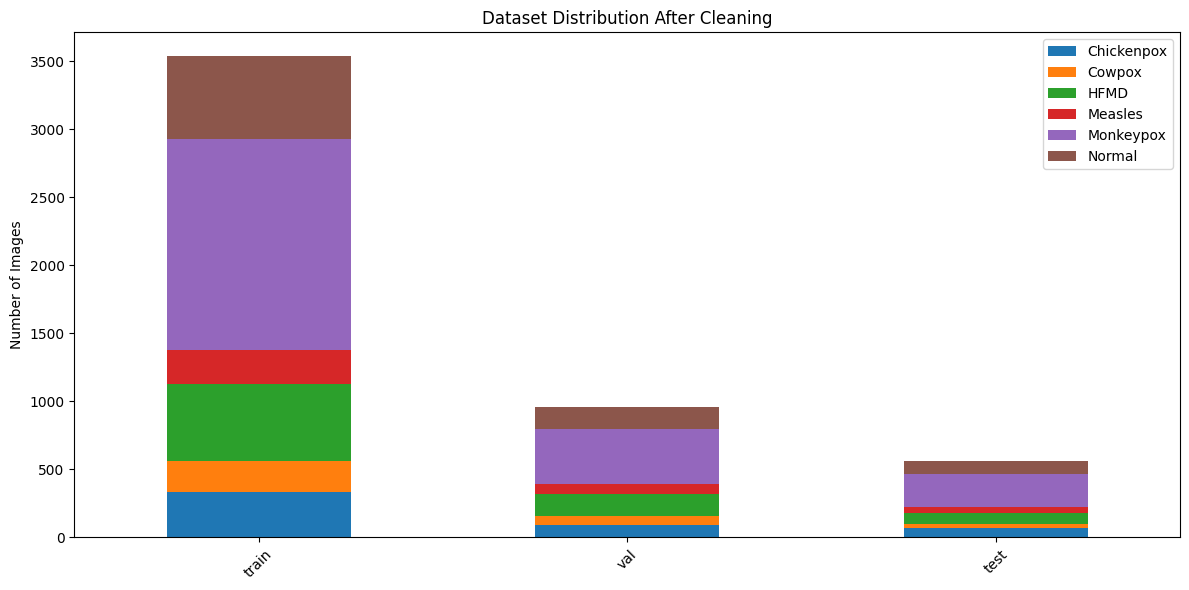

Classes: ['Chickenpox', 'Cowpox', 'HFMD', 'Measles', 'Monkeypox', 'Normal']

=== Creating Data Loaders ===
Dataset sizes - Train: 3537, Val: 957, Test: 560
Class distribution in training set:
Chickenpox: 332
Cowpox: 230
HFMD: 563
Measles: 251
Monkeypox: 1551
Normal: 610

=== Initializing Model ===
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 149MB/s]


Total parameters: 34,458,068
Trainable parameters: 34,458,068

=== Setting up Trainer ===

=== Starting Training ===
Starting training for 30 epochs...

Epoch 1/30
------------------------------
Batch 0/221, Loss: 1.8123
Batch 50/221, Loss: 1.8815
Batch 100/221, Loss: 1.3874
Batch 150/221, Loss: 1.6167
Batch 200/221, Loss: 1.2555
Train Loss: 1.4696, Train Acc: 40.87%
Val Loss: 1.1678, Val Acc: 62.90%
Learning Rate: 9.76e-06
New best model saved with validation accuracy: 62.90%

Epoch 2/30
------------------------------
Batch 0/221, Loss: 1.2118


In [ ]:
# Run the training
if __name__ == "__main__":
    if os.path.exists(zip_path):
        print("Dataset found! Starting training...")
        trainer, best_val_acc, test_acc = main(zip_path)

        if trainer is not None:
            print(f"\n🎉 Training completed successfully!")
            print(f"📊 Best Validation Accuracy: {best_val_acc:.2f}%")
            print(f"🧪 Test Accuracy: {test_acc * 100:.2f}%")
            print(f"💾 Model saved to Google Drive for future use")
        else:
            print("❌ Training failed. Check the error messages above.")
    else:
        print(f"❌ Dataset file not found at: {zip_path}")
        print("📁 Please make sure 'monkeypox_dataset.zip' is uploaded to your Google Drive")
        print("🔗 Or update the zip_path variable to match your file location")

# Additional utility functions for inference (save these for later use)
def load_model_for_inference(model_path='/content/drive/MyDrive/monkeypox_model/monkeypox_model.pth'):
    """Load saved model for inference"""
    checkpoint = torch.load(model_path, map_location=device)

    model = DilatedAttentionResNet(
        num_classes=checkpoint['num_classes'],
        pretrained=False
    )
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    return model, checkpoint['class_names']

def predict_image(model, image_path, class_names, device=device):
    """Predict single image"""
    transform = get_validation_augmentation()

    # Load and preprocess image
    image = np.array(Image.open(image_path).convert('RGB'))
    augmented = transform(image=image)
    image_tensor = augmented['image'].unsqueeze(0).to(device)

    # Predict
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = F.softmax(outputs, dim=1)
        predicted_class = torch.argmax(probabilities, dim=1).item()
        confidence = probabilities[0][predicted_class].item()

    return {
        'predicted_class': class_names[predicted_class],
        'confidence': confidence,
        'all_probabilities': {class_names[i]: prob.item() for i, prob in enumerate(probabilities[0])}
    }

print("\n🚀 Monkeypox Classification Model Ready!")
print("📝 To use the model later for inference, use the load_model_for_inference() and predict_image() functions")
print("💡 Model and dependencies are saved in /content/drive/MyDrive/monkeypox_model/")